<a href="https://colab.research.google.com/github/shubhm253/AI/blob/master/xgboostTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [3]:
from google.colab import files
uploaded = files.upload()

Saving financial_time_series.csv to financial_time_series.csv


In [0]:
dataset = pd.read_csv("financial_time_series.csv",index_col=[0], parse_dates=[0])

In [22]:
dataset.head()

,LogEqPrem,BookMarket
Year,,
1927-01-01,0.280823,0.374689
1928-01-01,0.313824,0.259667
1929-01-01,-0.112428,0.338458
1930-01-01,-0.288025,0.554745
1931-01-01,-0.563742,1.170732


In [0]:
def split_data(data, split_date):
    return data[data.index <= split_date].copy(), \
           data[data.index >  split_date].copy()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


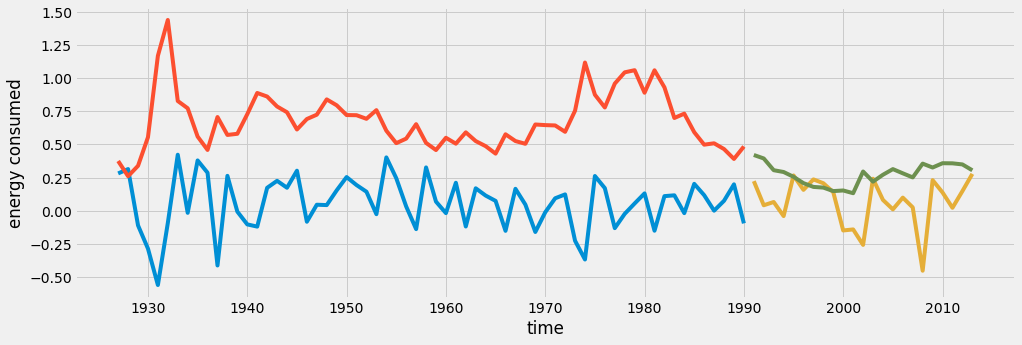

In [36]:
train, test = split_data(dataset, '1990-01-01')

plt.figure(figsize=(15,5))
plt.xlabel('time')
plt.ylabel('bookmarket')
plt.plot(train.index,train)
plt.plot(test.index,test)
plt.show()

In [0]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [0]:
X_train, y_train = create_features(train), train['BookMarket']
X_test, y_test   = create_features(test), test['BookMarket']

In [57]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Year,,,,,,,,
1927-01-01,0,5,1,1,1927,1,1,52
1928-01-01,0,6,1,1,1928,1,1,52
1929-01-01,0,1,1,1,1929,1,1,1
1930-01-01,0,2,1,1,1930,1,1,1
1931-01-01,0,3,1,1,1931,1,1,1
...,...,...,...,...,...,...,...,...
1986-01-01,0,2,1,1,1986,1,1,1
1987-01-01,0,3,1,1,1987,1,1,1
1988-01-01,0,4,1,1,1988,1,1,53


In [32]:
dataset.columns

Index(['LogEqPrem', 'BookMarket'], dtype='object')

In [0]:
X_train, y_train = create_features(train), train['BookMarket']
X_test, y_test   = create_features(test), test['BookMarket']

Year
1927-01-01    0.374689
1928-01-01    0.259667
1929-01-01    0.338458
1930-01-01    0.554745
1931-01-01    1.170732
                ...   
1986-01-01    0.498431
1987-01-01    0.508812
1988-01-01    0.465284
1989-01-01    0.390455
1990-01-01    0.484497
Name: BookMarket, Length: 64, dtype: float64

In [39]:
X_train.shape, y_train.shape

((64, 8), (64,))

In [40]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
        verbose=False) # Change verbose to True if you want to see it train

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[06:34:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

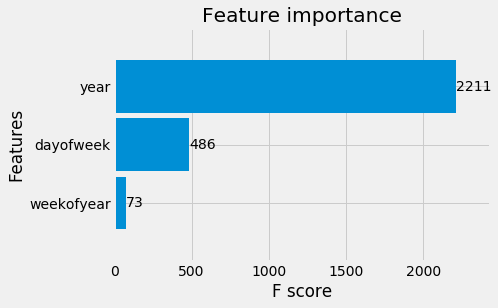

In [41]:
xgb.plot_importance(reg, height=0.9)

In [0]:
def plot_performance(base_data, date_from, date_to, title=None):
    plt.figure(figsize=(15,3))
    if title == None:
        plt.title('From {0} To {1}'.format(date_from, date_to))
    else:
        plt.title(title)
    plt.plot(dataset.index,dataset, label='data')
    plt.plot(X_test.index,X_test_pred, label='prediction')
    plt.legend()
    plt.xlim(left=date_from, right=date_to)

In [0]:
X_test_pred = reg.predict(X_test)

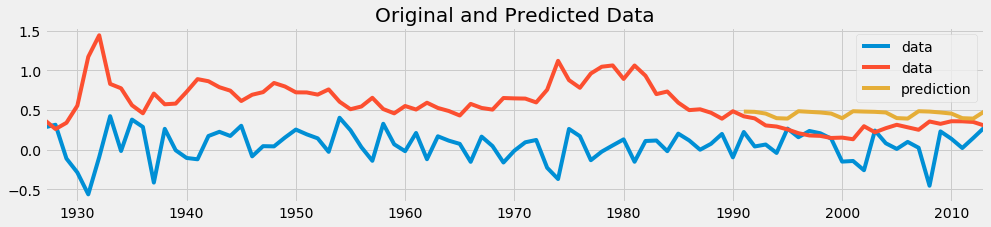

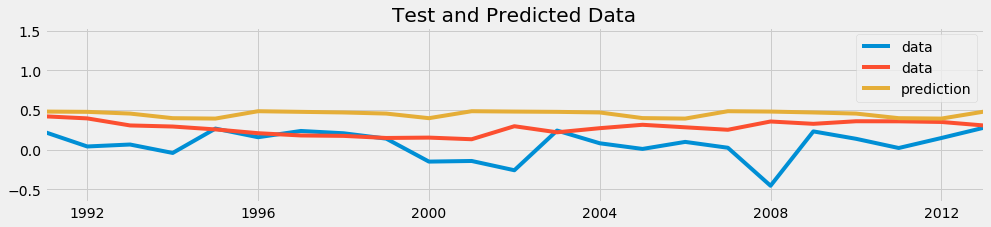

In [52]:
plot_performance(dataset, dataset.index[0].date(), dataset.index[-1].date(),
                 'Original and Predicted Data')

plot_performance(y_test, y_test.index[0].date(), y_test.index[-1].date(),
                 'Test and Predicted Data')

In [53]:
mean_squared_error(y_true=y_test,
                   y_pred=X_test_pred)

0.03864184719428439

In [54]:
mean_absolute_error(y_true=y_test,
                   y_pred=X_test_pred)

0.1740532261859123

In [0]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
mean_absolute_percentage_error(y_test,X_test_pred)

81.93612930647525